# Introduction

It is common knowledge that language changes over time, evidenced by phrases such as “bees knees” of other decades, but can this change in language be used to predict when a document was written?  I believe that it can, and so I will attempt to find specific spellings and phrases that show a higher frequency in certain decades of the Middle Ages.  I hope to be able to identify phrases that can be used to pinpoint a range of decades that a document is likely to have come from.

Previous research has often talked about how the inluence of the Norman conquest in 1066 caused there to be a change in vocabulary that continues to this day, and in 2018 I wrote a paper about the use of "lie" instead of "ly" as an adverb marker being indicative of a record being written in the late 1600s, however, not much has been done in the way of identifying features for a machine learning model.

My process for answering this dearth of knowledge includes downloading and cleaning various Middle English texts, such as stories of Merlin and King Arthur, cookbooks, and poetry.  I was able to find a website from the University of Michigan that allowed me to scrape a corpus of Early English writing, which made the scraping relatively simple to implement.

# Part 1: Scraping and Cleaning

During the first part of this project, I scraped nearly 3000 books from the sixteenth and seventeenth centuries from a corpus named Early English Books Online. Some of the centuries did not contain very much text, so I cut those out of my data set. Cleaning the data set was incredibly simple, as I merely had to get rid of some characters that would show up every once in a while, like the pipeline and slash characters that the text used to indicate page breaks and other printing phenomena. I also decided to shift everything to lowercase to cut down on the features examined, leaving phrases and speling as the choce features.  This also allowed me to ignore the fact that some books were written entirely in uppercase and some were not.

In terms of the reliability of the data, I believe it all to be accurate, given that it was put together by several universities that were tring to make a corpus that was easily searchable and could be used for analysis on Early Modern English. I do not foresee any "hidden agendas" that might skew the data with which I am concerned. Similarly, I do not believe there to be values that should concern me besides the occasional illustration or narration tag that shows up in the text. In conclusion, this data set was created specifically for analyses similar to this, and is very suited to it.

Below I include the code used to scrape and clean the data in executable files on one of the lab computers. There was no robots.txt file, so I encoded a regex to skip any books that still had a copyright.  I then used the command line to move the files into folders labeled by the publication decade of the books contained therein.


In [ ]:
import re
import time
import requests
from bs4 import BeautifulSoup as b

#try to avoid copyright infringement
copyright=re.compile('[pP]rohibit(ed|s)')
full_text=re.compile('View entire text')
#start off at the beginning browse by title
base_url = 'https://quod.lib.umich.edu/e/eebo?cginame=text-idx;id=navbarbrowselink;key=title;page=browse'
base_soup = b(requests.get(base_url).text,'html.parser')
#navigate to the row of letters
first_hierarchy = base_soup.find_all(href=True,class_='browsenav_r1')
for i in first_hierarchy[:26]:
    #navigate to the row of subletters
    next_page = b(requests.get(i.attrs['href']).text,'html.parser')
    titlestart=next_page.find_all(href=True,class_='browsenav_r2')
    for j,k in enumerate(titlestart):
        if j>10:
            break
        time.sleep(1)
        current_page=b(requests.get(k.attrs['href']).text,'html.parser')
        #grab the list of browselistitem
        
        titles = current_page.find_all(class_='browsecell')
        for ii,jj in enumerate(titles):
            if ii > 20:
                break
            if ii%2==0:
                #alternates between year and link to book
                author_year = jj.text
            else:
                book = b(requests.get(jj.contents[0].attrs['href']).text,'html.parser')
                text = []
                if book.find(name='p',string=copyright) is not None:  #check the copyright area.
                    pass
                contents = book.find_all(class_='buttonlink')[-1].contents[0]
                time.sleep(1)
                page = b(requests.get(contents.attrs['href']).text,'html.parser')
                accept = page.find(name='a')
                actual = b(requests.get(accept.attrs['href']).text,'html.parser')
                for ss in actual.find_all(name='p',limit=4000):
                    text.append(ss.string)
                #write the text to a file
                with open(author_year.replace('.','').replace('/','')+'.txt','a+') as outfile:
                    for aa in text:
                        if aa is not None:
                            outfile.write(aa)
                            outfile.write('\n')


In [ ]:
from glob import iglob 
for i in iglob('*.txt'):
    with open(i,'r') as infile:
        contents = infile.readlines()
    for j in range(len(contents)):
        if contents[j] in [' [illustration] ',' [narration]']:  
            #there are some of these scattered throughout the data.
            contents.remove(contents[j])
            pass
        contents[j]=contents[j].lower().replace('/','').replace('|','') 
        #there are some odd characters in the data.
        with open(i, 'w') as outfile:
            outfile.writelines([j + '\n' for j in contents])


Here I include a sample of the data after cleaning and scraping.  Note the odd spellings that may be markers of specific eras.

"in the begynnynge and endynge of all good werkes worshyp & thankynge be to almyghty god  maker & byer of all mākynde  begynner and ender of all goodnes  without whose gyfte & helpe no maner vertue is ne may be  whether it be in thought  wyll  or dede  than what euer we synfull creatures thynke or do speke or wryte  that may tourne in to proufyte of mannes soule  to god onely be the worshyp that sente al grace  to vs no praysynge  for of vs without hym cometh no thynge but fylthe & synne. now than good god of his endeles myght & plenteuous goodnes graūte me grace to thynke somwhat of his dere loue & how he sholde be loued  of that same loue some wordes to wryte whiche may to hym be worshyp  to the wryter mede  and proufytable to the reder. amen."

# Feature Engineering: N-Grams

In addition to single words and their spellings, I decided to add n-grams (groups of adjacent words) of the text as features.  I chose n-grams of lengths 2-5, and looked at the most common ones for each decade.  Some of the decades didn't have sufficient n-grams for them to be statistically significant, so I won't use that feature for them, but many of the other decades had a few I could use.

The reason for choosing to make n-grams was that they allow the program to look at phrases that were common, and may be important in determining the age of a document.  My method of choosing these phrases was by printing out all the most common phrases for each group of two to five words by decade, and choosing some that weren't trivial, i.e. not "he is."

The choices for features are reflected in the code used to construct the dataframe.  In each case, I wanted to use a word that would show up frequently enough to be statistically significant and had at least one alternate spelling.  This was to be able to track the usage of each over time.

In [6]:
import nltk
from glob import glob
import pandas as pd
import os

class cd:
    """Context manager for changing the current working directory"""
    def __init__(self, newPath):
        self.newPath = os.path.expanduser(newPath)

    def __enter__(self):
        self.savedPath = os.getcwd()
        os.chdir(self.newPath)

    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)
import nltk.data
import re
from nltk.util import ngrams
from nltk.corpus import PlaintextCorpusReader, stopwords
stops = stopwords.words('english') + ['thou','thy']
#get the list of directories
dirs = glob('*/')
punctuation = re.compile(r'[\W]')
punct = [',','.','&','{','}','?',"'",'-',';',':','|','(',')','[',']','!']
#for everything in the list
names=dict()
for d in dirs:
    #make each of the directories a temporary corpus
    #also make a list of all the n-grams for 2<=n<=5, for common phrasings
    name = d[:-1]
    words = [list() for i in range(2,5)]
    with cd(d):
        corpus = PlaintextCorpusReader('./','.*')
        tokens =[token for token in corpus.words() if not punctuation.match(token)]
        grams = list(ngrams(tokens,2))
        n=len(grams)
        gramscount= [(j,grams.count(j)/n) for j in [('your','self'),('our','selfe'),('him','self')]]
        stuff = corpus.words()
        morphemes = [l for l in stuff if l not in stops and l not in punct]
        #make a pseudo-dictionary for the single words
        n=len(morphemes)
        series = [(l,morphemes.count(l)/n) for l in ['have','haue','good','goode','never','neuer',
                                                     'come','cum','unto','vnto','which','whych','kyng','king','kynge',
                                                     'verbe','verb','whiche','hath','has','lorde','lord','yourself',
                                                     'ourself','himself','thynge','thing']] + [('NumWords',n)]
        series = dict(series+gramscount)
    names[name]=series
data = pd.DataFrame(names).transpose()
data.sort_index(inplace=True)
data.to_csv(path_or_buf='spellingData.csv')

# Data Visualizations

Now the data is ready to be graphed.  This will allow us to compare the variation in spelling and phrasing over time.  One possible pitfall is the lack of data in some decades, as evidenced by the following graph of the number of words in each decade.

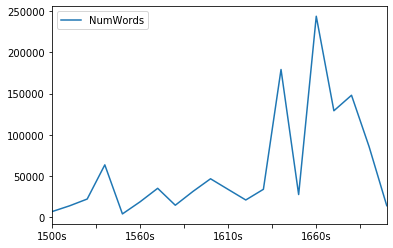

In [21]:
from matplotlib import pyplot as plt
import pandas as pd
data = pd.read_csv('spellingData.csv',index_col=0)
data.plot(y='NumWords')
plt.savefig('corpusSize.png')

Note that there is a significant difference in later years, likely due to the increase of literacy and greater availability of materials.  To counteract this, I found the ratio of each inividual word compared to the total words of the decade, normalizing the data.

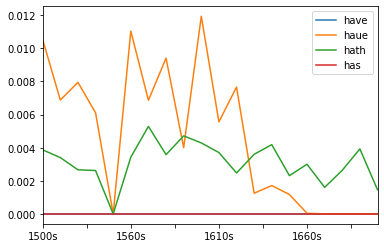

In [22]:

data.plot(y=['have','haue','hath','has'])
plt.savefig('have.png')
plt.show()

As shown by the data, the spelling "haue" was used far more than "have" for nearly the entire period, making it a poor feature. By the same reasoning, it is easy to see that "hath" is also a poor choice of feature.

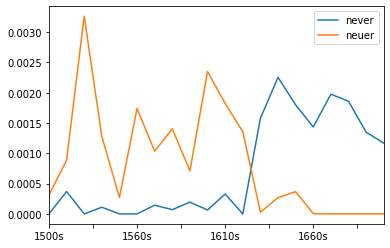

In [23]:
data.plot(y=['never','neuer'])
plt.savefig('never.png')
plt.show()

In contrast to the previous two examples, the spelling of "never" seems to be a good indicator of when something was written, mostly restricting it to the 16th century.

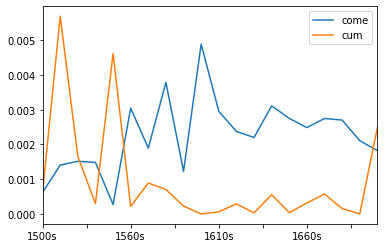

In [24]:
data.plot(y=['come','cum'])
plt.savefig('come.png')
plt.show()

While not as immediately useful as "never," the difference between "come" and "cum" is sufficient to be a worthwile feature, as the two lines tend to be fairly far apart.

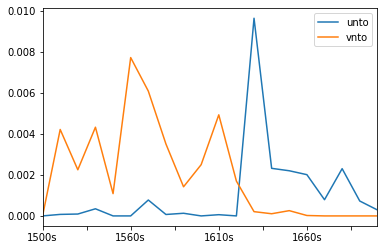

In [25]:
data.plot(y=['unto','vnto'])
plt.savefig('unto.png')
plt.show()

We see a very similar plot to "never", meaning that this might be another significant feature, though it may not be as useful to use the two of them together.  However, "unto" is a much more common word, which means that, of the two lemmata, it would likely be better to use "unto."

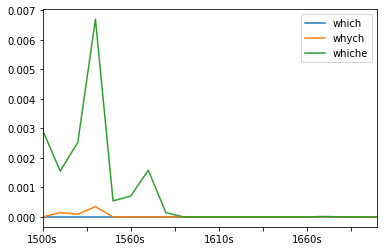

In [26]:
data.plot(y=['which','whych','whiche'])
plt.savefig('which.png')
plt.show()

Looking at this plot shows us that "whych" may be a decent indicator for the first half of the 16th century, though it may be that the corpus is too small to be conclusive about its utility.

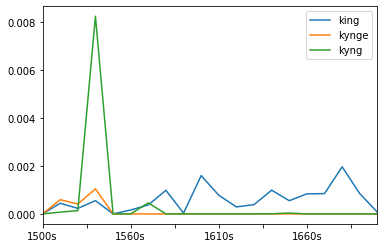

In [27]:
data.plot(y=['king','kynge','kyng'])
plt.savefig('king.png')
plt.show()

According to the data, the word "king" is an amazing indicator of when something was written, particularly the spelling "kyng."

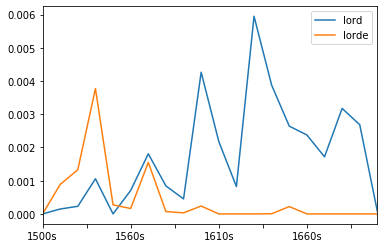

In [28]:
data.plot(y=['lord','lorde'])
plt.savefig('lord.png')
plt.show()

Overall, "lord" is a fairly decent feature, but it has a period of overlap with its variant, which makes it less useful than other words.

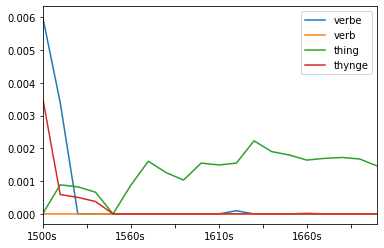

In [29]:
data.plot(y=['verbe','verb','thing','thynge'])
plt.savefig('verbthing.png')
plt.show()

Both of these seem to be fair indicators for the 1500s, though it may be due to a lack of material that talks about verbs.

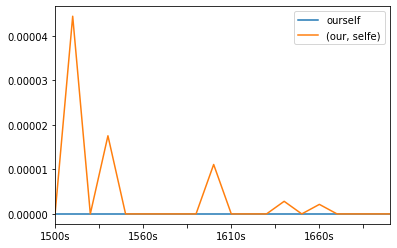

In [19]:
data.plot(y=['ourself',('our', 'selfe')])
plt.show()

This was the only n-gram that showed up enough to have been useful, but, as we can see, it doesn't contribute any information, as it appears the "modern" variant had not yet appeared in the literature.


# Conclusion

The data indicate that some of the most useful words for the sixteenth and seventeenth centuries are "kynge," "lorde," "vnto," "come," and their variants.  While other words are also useful, these were the words that showed up most frequently throughout the corpus.  Another conclusion from this data set is, contrary to my previous supposition, there were no phrases that were inherently useful in identifying time periods, as the phrases did not change throughout the entirety of the corpus.  Despite this, it has been shown that there are features that may be useful for a model predicting when something was written based on the text contained, which may allow future archaeologists and linguists to use less destructive methods to assign dates to the documents they discover. Further research will require a larger corpus or expansion into model testing.